# Procgen-PPO-RND implementation

PPO-RND implemenetation for the environemnts in the procgen benchmark.

In [1]:
import gym
from gym.wrappers import GrayScaleObservation
from gym.wrappers import FrameStack
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from keras import backend as K
from collections import deque
import random
from matplotlib import pyplot as plt
from threading import Thread
import math

# change keras setting to use the conv2d NN passing the channel first (as returned from the FrameStack wrapper)
K.set_image_data_format('channels_first')

## Memory

Class used to memorize the trajectories and calculate the advantages

In [2]:
class Memory(object):
    
    STATE = 0
    ACTION = 1
    ACTION_PROB = 2
    EXTRINSIC_REWARD = 3
    INTRINSIC_REWARD = 4
    DONE = 5
    
    def __init__(self, n_trajectories, e_gamma = 0.999, i_gamma = 0.99, e_lambda = 0.95, i_lambda = 0.95, discount_rate = 0.98):
        self.trajectories = np.empty(n_trajectories, dtype=object)
        self.e_gamma = e_gamma
        self.i_gamma = i_gamma
        self.e_lambda = e_lambda
        self.i_lambda = i_lambda
        
        self.discount_rate = discount_rate
              
    def collect(self, state, action, action_prob, extrinsic_reward, intrinsic_reward, done, i_episode):
        if (self.trajectories[i_episode] == None):
            self.trajectories[i_episode] = deque(maxlen=N_STEPS)
        self.trajectories[i_episode].append((state, action, action_prob, extrinsic_reward, intrinsic_reward, done))
        
    def calculate_advantages(self, reward_standard_deviation_estimate):
        advantages = []
        extrinsic_TDresiduals = []
        intrinsic_TDresiduals = []
        extrinsic_discounts = []
        intrinsic_discounts = []
        
        for trajectory in self.trajectories:
            
            advantage_trajectory = [] #list of advantages for each element in a single trajectory
            e_delta = []
            i_delta = []
            e_G = []
            i_G = []

            old_v_e_t = ppo.return_v_extrinsic_values(trajectory[-1][self.STATE])
            v_e_t = ppo.return_v_extrinsic_values(trajectory[-2][self.STATE] )
            
            e_delta.append(trajectory[-2][self.EXTRINSIC_REWARD] + 
                           self.e_gamma*old_v_e_t - v_e_t)
            e_G.append(trajectory[-2][self.EXTRINSIC_REWARD] + self.discount_rate*trajectory[-1][self.EXTRINSIC_REWARD])
            e_old_advantage = e_delta[-1]
            
            old_v_e_t = v_e_t
            
            old_v_i_t = ppo.return_v_intrinsic_values(trajectory[-1][self.STATE])
            v_i_t = ppo.return_v_intrinsic_values(trajectory[-2][self.STATE] )
            #normalizing the intrinisc reward before calculating the advantage
            i_delta.append( (trajectory[-2][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate) + 
                           self.e_gamma*old_v_i_t - v_i_t )
            i_G.append((trajectory[-2][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate) + self.discount_rate*(trajectory[-1][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate))
            i_old_advantage = i_delta[-1]
            
            old_v_i_t = v_i_t
            
            advantage_trajectory.append(e_old_advantage[0] + i_old_advantage[0])
            
            for i in range(len(trajectory)-3,-1,-1):
                v_e_t = ppo.return_v_extrinsic_values(trajectory[i][self.STATE])
                e_delta.append(trajectory[i][self.EXTRINSIC_REWARD] + 
                               self.e_gamma*old_v_e_t - v_e_t)
                e_G.append(trajectory[i][self.EXTRINSIC_REWARD] + self.discount_rate*e_G[-1])
                e_old_advantage = e_delta[-1] + self.e_gamma*self.e_lambda*e_old_advantage                                    
                 
                old_v_e_t = v_e_t
                
                normalized_intrinsic_reward = trajectory[i][self.INTRINSIC_REWARD] / reward_standard_deviation_estimate
                v_i_t = ppo.return_v_intrinsic_values(trajectory[i][self.STATE])
                i_delta.append(normalized_intrinsic_reward + 
                               self.i_gamma*old_v_i_t - v_i_t)
                
                i_G.append(normalized_intrinsic_reward + self.discount_rate*i_G[-1])
                i_old_advantage = i_delta[-1] + self.i_gamma*self.i_lambda*i_old_advantage                                    
                  
                old_v_i_t = v_i_t
                
                advantage_trajectory.append(i_old_advantage[0] + e_old_advantage[0])  
        
                                                                                                                                                                       
            extrinsic_TDresiduals.append(e_delta)
            intrinsic_TDresiduals.append(i_delta)
            
            extrinsic_discounts.append(e_G)
            intrinsic_discounts.append(i_G)
                           
            advantages.append(advantage_trajectory)
            
        #flat all trajectories in a single deque adding the advantages (easier to sample random batches)
        self.flat_trajectories(self.trajectories, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_discounts, intrinsic_discounts)
    
    def flat_trajectories(self, trajectories, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_G, intrinsic_G):
        
        size = 0
        for trajectory in trajectories:
            size = size + len(trajectory)
        
        self.flatten_trajectories = deque(maxlen=size)
        
        for trajectory, advantage, e_delta, i_delta, e_discount, i_discount in zip(trajectories, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_G, intrinsic_G):
            len_trajectory = len(trajectory)
            for i in range(len_trajectory-2,-1,-1):
                self.flatten_trajectories.append((trajectory[i][self.STATE], 
                                                  trajectory[i][self.ACTION], 
                                                  trajectory[i][self.ACTION_PROB], 
                                                  trajectory[i][self.EXTRINSIC_REWARD], 
                                                  trajectory[i][self.INTRINSIC_REWARD], 
                                                  advantage[len_trajectory-2-i], 
                                                  e_delta[len_trajectory-2-i], 
                                                  i_delta[len_trajectory-2-i], 
                                                  e_discount[len_trajectory-2-i], 
                                                  i_discount[len_trajectory-2-i], 
                                                  trajectory[i][self.DONE]))
                #print("{}: i discount {} v_I {} A_I {}".format(i, i_discount[len_trajectory-2-i],ppo.return_v_intrinsic_values(trajectory[i][self.STATE]),advantage[len_trajectory-2-i] ))
                del trajectory[i]
        
    #pick a random batch example from the flatten list of trajectories
    def sample_experiences(self, batch_size):
        if (len(self.flatten_trajectories) >= batch_size):
            indices = np.random.permutation(len(self.flatten_trajectories))[:batch_size]
        else:
            indices = np.random.permutation(len(self.flatten_trajectories))
        batch = [self.flatten_trajectories[index] for index in indices]
        #delete form the memory the used obervations (use every sample once)
        #comment the two following lines to use multiple times the same samples
        #for index in sorted(indices, reverse=True):
        #    del self.flatten_trajectories[index]
        states, actions, actions_prob, e_rewards, i_rewards, advantages, e_TDresiduals, i_TDresiduals, e_discounts, i_discounts, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(11)]
        return states, actions, actions_prob, e_rewards, i_rewards, advantages, e_TDresiduals, i_TDresiduals, e_discounts, i_discounts, dones
        
    def reset(self):
        for trajectory in self.trajectories:
            trajectory.clear()
        self.flatten_trajectories.clear()

In [3]:
class RND(object):
    
    input_shape = [1,64,64] 
    n_outputs = 200
    
    N_intrinsic_rewards = 0 #number of intrinsic reward received
    intrinisc_reward_mean = 0.0 #mean of the intrinsic rewards received
    reward_M2 = 0.0 #sum of squares of differences from the current mean
    
    N_observations = 0 #number of observations received
    observations_mean = np.zeros([64,64] ,'float64') #mean of the observations received
    observation_M2 = np.zeros([64,64] ,'float64') #sum of squares of differences from the current mean
    
    def __init__(self, env, n_normalization_steps = 40):
        self.target = self.create_target()
        self.predictor = self.create_predictor()
        
        self.MSE = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        
        self.initialize_standard_deviation_estimate(env, n_normalization_steps)
        
    #create the NN of the target
    def create_target(self):
        target = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs) ])
        return target
        
    #create the NN of the predictor
    def create_predictor(self):
        predictor = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs) ])
        return predictor
    
    def train_predictor(self, observations):
        # extrinsic critic (rewards from the envirnoment)
        observations = np.array(observations)
        observations = self.normalize_observations(observations)
        # covert shape [BATCH_SIZE, 4, 84, 84] in [BATCH_SIZE,1,84,84]
        observations = [observation[-1,0:observation.shape[1], 0:observation.shape[2]] for observation in observations]
        observations = tf.expand_dims(observations, axis = 1)
        target_values = self.target.predict(observations)
        with tf.GradientTape() as tape:
            all_values = self.predictor(observations)
            loss = tf.reduce_mean(self.MSE(target_values, all_values))
        grads = tape.gradient(loss, self.predictor.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.predictor.trainable_variables))
        
    def calculate_intrinsic_reward(self, observation):
        #passing a (4,84,84) stacked frame from the environment
        observation = np.array(observation).astype(np.float32)
        #picking the last frame
        observation = observation[-1, 0:observation.shape[1], 0:observation.shape[2]]
        #normalize the last frame
        s = self.calculate_observation_standard_deviation()
        observation = self.normalize_observation(observation, s)
        #calculate intrinsic reward on the last frame
        observation = tf.expand_dims(observation, axis=0)
        f_target = self.target.predict(tf.expand_dims(observation, axis=0))
        f_predictor = self.predictor.predict(tf.expand_dims(observation, axis=0))
        
        reward =  pow(np.linalg.norm(f_predictor - f_target), 2)*100
            
        return reward
    
    def initialize_standard_deviation_estimate(self, env, n_normalization_steps):
        #self.observations_mean = np.zeros([64,64] ,'float64') #mean of the intrinsic rewards received
        #self.observation_M2 = np.zeros([64,64] ,'float64') #sum of squares of differences from the current mean
        
        obsevation = env.reset()
        
        for i_step in range(n_normalization_steps):
            observation, reward, done, info = env.step(env.action_space.sample())
            observation = np.array(observation).astype(np.float32)
            for frame in observation:
                self.update_observation_normalization_param(frame)
    
    def update_observation_normalization_param(self, observation):
        #cicle trhough the 4 images that makes up for an observation
        for obs in observation:
            #obs_mean = np.mean([obs_dim], axis=0)
            self.N_observations = self.N_observations + 1
            delta = obs - self.observations_mean
            self.observations_mean = self.observations_mean + delta/self.N_observations # mean_N = mean_{N-1} + (obs_t - mean_{N-1}) / N
            self.observation_M2 = self.observation_M2 + delta*(obs - self.observations_mean)
        
    def calculate_observation_standard_deviation(self):
        standard_deviation = np.sqrt( self.observation_M2 / (self.N_observations - 1))
        return standard_deviation
    
    def normalize_observations(self, observations):

        norm_obs = []
        s = self.calculate_observation_standard_deviation()
        for observation in observations:
            norm_obs.append(self.normalize_observation(observation, s))
        normalized_obs = tf.stack([norm_obs[i] for i in range(len(norm_obs))], 0)

        return normalized_obs
    
    def normalize_observation(self, observation, standard_deviation):
        t = observation - self.observations_mean
        normalized_obs = np.clip(np.divide(t, standard_deviation, out=np.zeros_like(t), where=standard_deviation!=0), a_min =-5, a_max = 5)       
        return normalized_obs
    
    #Using welford's algorithm
    def update_reward_normalization_param(self, i_reward):
        self.N_intrinsic_rewards = self.N_intrinsic_rewards + 1
        delta = i_reward - self.intrinisc_reward_mean
        self.intrinisc_reward_mean = self.intrinisc_reward_mean + delta/self.N_intrinsic_rewards # mean_N = mean_{N-1} + (i_t - mean_{N-1}) / N
        self.reward_M2 = self.reward_M2 + delta*(i_reward - self.intrinisc_reward_mean)
        
    def calculate_reward_standard_deviation(self):
        standard_deviation = math.sqrt( self.reward_M2 / (self.N_intrinsic_rewards - 1))
        print("===============================================================")
        print("STANDARD DEVIATION {}".format(standard_deviation))
        print("===============================================================")
        return standard_deviation
    
    def save(self, path = ".\\saved_weights\\rnd\\"):
        self.target.save_weights(path + 'target_weights.h5')
        self.predictor.save_weights(path + 'predictor_weights.h5')
        
    def load(self, path = ".\\saved_weights\\rnd\\"):
        self.target.load_weights(path + 'target_weights.h5')
        self.predictor.load_weights(path + 'predictor_weights.h5')

# PPO class including the exploration bonus

$ s_{t+1} $ and $ r_t = r_{t+1}^{(e)} + r_{t+1}^{(i)} $  are the observed state/reward after the current action $ a_t $.

$ a_{T-1} $ is the last action taken and $ s_T $, $ r_T $ are the last observation/reward.

Actor parameter updated to maximize:
$  L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[min(r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t) + \beta H_t ] $

Critic update formula:
$ w_{t+1} = w_t + \alpha G_t\hat{v}(s_t,w)$

Probability ratio $ r_t(\theta) \doteq $
$ \pi_\theta(a_t | s_t) \over \pi_{\theta_{old}}(a_t | s_t) $

Advantage:
$ \hat{A}_t = \hat{A}_t^{(e)} + \hat{A}_t^{(i)} $

$ \quad \hat{A}_t^{(e)} \doteq \delta_t^{(e)} + (\gamma^{(e)}\lambda^{(e)})\delta_{t+1}^{(e)} + (\gamma^{(e)}\lambda^{(e)})^2\delta_{t+2}^{(e)} + ... + (\gamma^{(e)}\lambda^{(e)})^{T
-t-1}\delta_{T-1}^{(e)} = \delta_t^{(e)} + (\gamma^{(e)}\lambda^{(e)})\hat{A}_{t+1}^{(e)}$

$ \quad \hat{A}_t^{(i)} \doteq \delta_t^{(i)} + (\gamma^{(i)}\lambda^{(i)})\delta_{t+1}^{(i)} + (\gamma^{(i)}\lambda^{(i)})^2\delta_{t+2}^{(i)} + ... + (\gamma^{(i)}\lambda^{(i)})^{T
-t-1}\delta_{T-1}^{(i)} = \delta_t^{(i)} + (\gamma^{(i)}\lambda^{(i)})\hat{A}_{t+1}^{(i)}$

TD residual:

$ \quad \delta_t^{(e)}  \doteq r_t^{(e)} + \gamma^{(e)}\hat{v}^{(e)}(s_{t+1},w) - \hat{v}^{(e)}(s_t,w) $

$ \quad \delta_t^{(i)}  \doteq r_t^{(i)} + \gamma^{(i)}\hat{v}^{(i)}(s_{t+1},w) - \hat{v}^{(i)}(s_t,w) $ 

Discount return:

$ \quad G_t^{(e)} \doteq r_t^{(e)} + \gamma^{(e)} r_{t+1}^{(e)} + (\gamma^{(e)})^2 r_{t+2} + ... + (\gamma^{(e)})^{T-t+1} r_{T-t-1}^{(e)} = r_t^{(e)} + \gamma^{(e)} G_{t+1}^{(e)} $

$ \quad G_t^{(i)} \doteq r_t^{(i)} + \gamma^{(i)} r_{t+1}^{(i)} + (\gamma^{(i)})^2 r_{t+2} + ... + (\gamma^{(i)})^{T-t+1} r_{T-t-1}^{(i)} = r_t^{(i)} + \gamma^{(i)} G_{t+1}^{(i)} $

Entropy:
$ H_t \doteq $
$ - \sum \pi(a_t|s_t,\theta)log_2(\pi_{\theta}(a_t|s_t)) $

In [4]:
class PPO(object):
    
    input_shape = [4,64,64] 
    n_outputs = 9 #15 #wrapped_env.action_space.n
    
    def __init__(self, env, n_episodes = 1, train_steps = 100, epsilon = 0.1, alpha = 1, gamma = 0.99, e_lambda_par = 0.98, i_lambda_par = 0.98, n_normalization_steps = 300, train_predictor_keeping_prob = 0.5, beta = 1e-3):
        self.actor = self.create_actor()
        self.intrinsic_critic = self.create_critic()
        self.extrinsic_critic = self.create_critic()
        
        self.MSE = tf.keras.losses.mean_squared_error
        
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
        self.extrinsic_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
        self.intrinsic_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        
        self.train_steps = train_steps
        self.train_predictor_keeping_prob = train_predictor_keeping_prob
        
        self.memory = Memory(n_episodes)
        
        self.rnd = RND(env, n_normalization_steps)
        
    #create the NN of the actor
    # Given the state returns the probability of each action
    def create_actor(self):
        initializer = tf.keras.initializers.GlorotNormal()
        actor = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="tanh", input_shape = self.input_shape, kernel_initializer=initializer),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="tanh", kernel_initializer=initializer),
            keras.layers.Conv2D(filters=32, kernel_size = (2,2), strides=1, activation="tanh", kernel_initializer=initializer),
            keras.layers.Dense(256, kernel_initializer=initializer),
            #keras.layers.Dropout(0.4),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(self.n_outputs, kernel_initializer=initializer, activation = 'softmax') ])
        return actor
       
    #create the NN of the critic
    # Given the state returns the value function
    def create_critic(self):
        critic = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size = (3,3), strides=2, activation="relu", input_shape = self.input_shape),
            keras.layers.Conv2D(filters=32, kernel_size = (4,4), strides=2, activation="relu"),
            keras.layers.Conv2D(filters=32, kernel_size = (3,3), strides=1, activation="relu"),
            keras.layers.Dense(256),
            tf.keras.layers.Flatten(),
            keras.layers.Dense(1) ])
        
        return critic
      
    def play_one_step(self, env, observation, reward, i_episode, step):
        action, action_prob = self.select_action(observation)
        next_observation, next_reward, done, info = env.step(action)
        
        #the normalization of the intrinisc reward after before training
        i_reward = self.rnd.calculate_intrinsic_reward(observation)
        
        self.rnd.update_reward_normalization_param(i_reward)
        self.rnd.update_observation_normalization_param(observation)
        
        self.memory.collect(observation, action, action_prob, reward, i_reward, done, i_episode)
        if (step == N_STEPS-1):
            #for the last step i_reward is ri-calculated after training 
            #notice the last state will be the first state in the newxt run
            self.memory.collect(next_observation, action, action_prob, next_reward, i_reward, done, i_episode)
            
        return next_observation, action, next_reward, i_reward, done, info

        
    #select the action (returned as a number)
    def select_action(self, observation):
        
        action_probabilities = self.actor.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        action = np.random.choice(a = len(action_probabilities), p = action_probabilities)
        
        return action, action_probabilities[action]
    
    def train(self, batch_size):
        self.memory.calculate_advantages(self.rnd.calculate_reward_standard_deviation())
        
        for i_step in range(self.train_steps):
            done = self.training_step(batch_size)
            if (done):
                break
        
        self.memory.reset()
        
    #training done on the memory (the advantages must be calculated before hand)
    def training_step(self, batch_size):
        #get experiences (parts of a trajectory) from the memory
        
        states, actions, actions_prob, extrinsic_rewards, intrinsic_rewards, advantages, extrinsic_TDresiduals, intrinsic_TDresiduals, extrinsic_discounts, intrinsic_discounts, dones = self.memory.sample_experiences(batch_size)
        
        done = False
        if (len(states) == 0):
            return True
        if (len(states) != batch_size):
            done = True

        #compute the values for the update of the actor
        
        mask = tf.one_hot(actions, self.n_outputs)
        
        states = np.array(states)
        
        og_states = states
        states = np.array(states).astype(np.float32) / 255.
        
        with tf.GradientTape() as tape:
            current_actions_prob = self.actor(states)
            
            masked_action_prob = tf.reduce_sum(current_actions_prob*mask, axis=1, keepdims=True)
            old_actions_prob = tf.reshape(tf.convert_to_tensor(actions_prob), [len(states), 1])
            probability_ratio = tf.divide(tf.math.log(masked_action_prob + 1e-7), tf.math.log(old_actions_prob + 1e-7 ))
        
            #sobtitute nan values with zero (where given an array of True/false puy the element of the first array (tf.zeros_like(probability_ratio)) in the position where is True, the second (probability_ratio) where is False)
            probability_ratio = tf.where(tf.math.is_nan(probability_ratio), tf.zeros_like(probability_ratio), probability_ratio)
            
            surrogate_arg_1 = tf.math.multiply(probability_ratio, advantages)
            surrogate_arg_2 = tf.math.multiply(tf.keras.backend.clip(probability_ratio, 1-self.epsilon*self.alpha, 1+self.epsilon*self.alpha), advantages)
            
            entropy = - tf.reduce_sum(current_actions_prob*tf.divide(tf.math.log(current_actions_prob + 1e-10), tf.math.log(2.)), 1, keepdims=True )
            
            print(current_actions_prob[:2])
            
            L = - tf.minimum( surrogate_arg_1, surrogate_arg_2 ) - self.beta*entropy 

            loss = tf.reduce_mean(L)
          
        print("L {} = tf.min {} - entropy {}*{}".format(loss, tf.reduce_mean(tf.minimum( surrogate_arg_1 , surrogate_arg_2 )), self.beta, tf.reduce_mean(entropy)))
        
        actor_weights = self.actor.trainable_variables
        grads = tape.gradient(loss, actor_weights)
        self.actor_optimizer.apply_gradients(zip(grads, actor_weights))
        
        #extrinsic critic update
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(extrinsic_discounts).astype('float32')), (len(states), 1))
        
        with tf.GradientTape() as tape:
            v_values = self.extrinsic_critic(states)
            loss = tf.reduce_mean(self.MSE(target_v_values, v_values))
        grads = tape.gradient(loss, self.extrinsic_critic.trainable_variables)
        self.extrinsic_optimizer.apply_gradients(zip(grads, self.extrinsic_critic.trainable_variables))
        
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(intrinsic_discounts).astype('float32')), (len(states), 1))
        
        #intrinsic critic update
        with tf.GradientTape() as tape:
            v_values = self.intrinsic_critic(states)
            loss = tf.reduce_mean(self.MSE(target_v_values, v_values))
        grads = tape.gradient(loss, self.intrinsic_critic.trainable_variables)
        self.intrinsic_optimizer.apply_gradients(zip(grads, self.intrinsic_critic.trainable_variables))
        
        #choosing samples with keeping probability to train the predictor
        keep = random.random()
        if (keep <= self.train_predictor_keeping_prob):
            self.rnd.train_predictor(og_states)
        
        return done
    
    def return_v_extrinsic_values(self, observation):
        v_e = self.extrinsic_critic.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        return v_e
    
    def return_v_intrinsic_values(self, observation):
        v_i = self.intrinsic_critic.predict(tf.expand_dims(np.array(observation).astype(np.float32) / 255., axis=0))[0]
        return v_i
    
    def update_hyperparam(self):
        #self.alpha = self.alpha - 0.1/N_EPOCHS
        #self.actor_optimizer.lr.assign(1e-4 * self.alpha)
        self.beta = self.beta - 0.004 # from 0.09 to 0.07 in 10 epochs
    
    def save(self, path = ".\\saved_weights\\rnd\\"):
        self.actor.save_weights(path + 'actor_weights.h5')
        self.extrinsic_critic.save_weights(path + 'e_critic_weights.h5')
        self.intrinsic_critic.save_weights(path + 'i_critic_weights.h5')
        self.rnd.save()
        
    def load(self, path = ".\\saved_weights\\rnd\\"):
        self.actor.load_weights(path + 'actor_weights.h5')
        self.extrinsic_critic.load_weights(path + 'e_critic_weights.h5')
        self.intrinsic_critic.load_weights(path + 'i_critic_weights.h5')
        self.rnd.load()

In [5]:
class collect_trajectory(Thread):
    
    def __init__(self, env, i_agent, starting_observation, starting_reward):
         
        Thread.__init__(self)   
        self.n_agent = i_agent
        self.rewards = [] 
        
        self.env = env
        
        self.starting_observation = starting_observation
        self.starting_reward = starting_reward
        
            
    def run(self):
        
        self.observation = self.starting_observation
        self.extrinsic_reward = self.starting_reward
        
        extrinsic_episode_reward = 0.0
        intrinsic_episode_reward = 0.0
        self.n_episodes = 0.0
        self.extrinsic_tot_reward = 0.0
        self.intrinsic_tot_reward = 0.0
        
        self.intrinsic_rewards = []
        self.last_episode_step = []
        
        for i_step in range(N_STEPS):   
            self.observation, action, self.extrinsic_reward, intrinsic_reward, done, info = ppo.play_one_step(self.env, self.observation, self.extrinsic_reward, self.n_agent, i_step)
            
            extrinsic_episode_reward = extrinsic_episode_reward + self.extrinsic_reward
            intrinsic_episode_reward = intrinsic_episode_reward + intrinsic_reward
            
            self.intrinsic_rewards.append(intrinsic_reward)
            
            #continuing task. if an episode is done we continue until completing the number of steps
            if (done):
                
                self.last_episode_step.append(i_step)
                
                self.extrinsic_tot_reward = self.extrinsic_tot_reward + extrinsic_episode_reward
                self.intrinsic_tot_reward = self.intrinsic_tot_reward + intrinsic_episode_reward
                self.n_episodes = self.n_episodes + 1
                episode_reward = 0.0
                
        if (self.n_episodes == 0):
            self.extrinsic_tot_reward = extrinsic_episode_reward
            self.intrinsic_tot_reward = intrinsic_episode_reward
        
        if (self.n_episodes > 0):
            print("Exiting {} after {} episodes. Average ex reward: {} in reward: {}".format(self.n_agent, self.n_episodes, self.extrinsic_tot_reward/self.n_episodes, self.intrinsic_tot_reward/self.n_episodes))
        else:
            print("Exiting {} after {} episodes. Average ex reward: {} in reward: {}".format(self.n_agent, self.n_episodes, self.extrinsic_tot_reward, self.intrinsic_tot_reward))
    
    
    def get_reward_average(self):
        if (self.n_episodes > 0):
            return (self.extrinsic_tot_reward/self.n_episodes, self.intrinsic_tot_reward/self.n_episodes)
        else:
            return (self.extrinsic_tot_reward, self.intrinsic_tot_reward)
        
    def get_data(self):
        return self.intrinsic_rewards, self.last_episode_step
    
    def get_observation(self):
        return self.observation
    
    def get_reward(self):
        return self.extrinsic_reward
    
    def get_num_agent(self):
        return self.n_agent

In [6]:
N_STEPS_NORMALIZATION = 50
N_EPOCHS = 100
N_EPISODES =  4 # in multi-agent this is the number of agents (each agent collects 1 trajectory)
N_STEPS = 128 # max number of step for each episode

TRAIN_STEPS = 32 # number of max steps done during training. if the number of samples is less than TRAIN_STEPS*BATCH_SIZE will stop early after completing the training on all the samples
BATCH_SIZE = 128

environment = "procgen:procgen-coinrun-v0"

#env used to initialize the parameters inside PPO and RND
norm_basic_env = gym.make(environment, distribution_mode="exploration")
norm_wrapped_env = GrayScaleObservation(norm_basic_env)
norm_stack_env = FrameStack(norm_wrapped_env, 4) 

ppo = PPO(norm_stack_env, 
          n_episodes = N_EPISODES, 
          train_steps = TRAIN_STEPS, 
          n_normalization_steps = N_STEPS_NORMALIZATION, 
          train_predictor_keeping_prob = 0.45,
          beta = 9e-2)

e_rewards = []
i_rewards = []

intrinsic_rewards = [] 
last_episode_step = []

envs = []
initial_observations = {}
initial_rewards = {}

for i_env in range(N_EPISODES):
        basic_env = gym.make(environment, distribution_mode="exploration")
        wrapped_env = GrayScaleObservation(basic_env)
        envs.append(FrameStack(wrapped_env, 4))
        initial_observations[i_env] = envs[-1].reset()
        initial_rewards[i_env] = 0
        
highest_average_reward = 0
        
for i_epoch in range(N_EPOCHS):
    extrinsic_epoch_reward = 0.0
    intrinsic_epoch_reward = 0.0
    agents = []
    for i_agent in range(N_EPISODES):
        agents.append(collect_trajectory(env = envs[i_agent], i_agent = i_agent, starting_observation = initial_observations[i_agent], starting_reward = initial_rewards[i_agent]))
    initial_observations.clear()
    initial_rewards.clear()
    for agent in agents:
        agent.start()
    for agent in agents:
        agent.join()
        initial_observations[agent.get_num_agent()] = agent.get_observation()
        initial_rewards[agent.get_num_agent()] = agent.get_reward()
        extrinsic_reward_average, intrinsic_reward_average = agent.get_reward_average()
        extrinsic_epoch_reward = extrinsic_epoch_reward + extrinsic_reward_average
        intrinsic_epoch_reward = intrinsic_epoch_reward + intrinsic_reward_average
    e_rewards.append(extrinsic_epoch_reward/N_EPISODES)
    i_rewards.append(intrinsic_epoch_reward/N_EPISODES)
    rews, eps = agents[0].get_data()
    intrinsic_rewards.append(rews) 
    last_episode_step.append(eps)
    print("Epoch: {} ended with average extrinsic reward: {} intrinsic reward {} \n".format(i_epoch, extrinsic_epoch_reward/N_EPISODES, intrinsic_epoch_reward/N_EPISODES) )  
    
    if (i_epoch % 10 == 0):
        ppo.save()
    
    ppo.train(batch_size = BATCH_SIZE)
    
    if (i_epoch <= 20):
        ppo.update_hyperparam()
    
for i_env in range(N_EPISODES):
    envs[i_env].close()

Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 25552.418653705172
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 23721.95424392096
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 26292.96043866386
Exiting 0 after 0.0 episodes. Average ex reward: 0.0 in reward: 18260.514733898985
Epoch: 0 ended with average extrinsic reward: 0.0 intrinsic reward 23456.962017547245 

STANDARD DEVIATION 174.32985410104413
tf.Tensor(
[[0.10283897 0.11341856 0.11772534 0.10126746 0.11518453 0.11485527
  0.09782226 0.12478766 0.11209999]
 [0.10460553 0.11051684 0.11505304 0.10102694 0.11429203 0.11365078
  0.10055426 0.12614304 0.11415753]], shape=(2, 9), dtype=float32)
L -16.699787139892578 = tf.min 16.414844512939453 - entropy 0.09*3.166029453277588
tf.Tensor(
[[0.13332663 0.13853444 0.09753384 0.11519521 0.09544816 0.14547679
  0.08455897 0.09627239 0.09365356]
 [0.13235988 0.1296503  0.0988758  0.13014847 0.09875511 0.1419397
  0.08647246 0.08933517 0.092

tf.Tensor(
[[0.33420625 0.09085277 0.09501056 0.05272329 0.09455658 0.0711282
  0.07825933 0.08184788 0.10141508]
 [0.26652536 0.09751739 0.09770683 0.05705065 0.09865201 0.10191046
  0.08723414 0.09047798 0.10292523]], shape=(2, 9), dtype=float32)
L -18.92180824279785 = tf.min 18.659801483154297 - entropy 0.09*2.9111857414245605
tf.Tensor(
[[0.3333746  0.09450667 0.0960327  0.05054355 0.09244104 0.07242281
  0.07865454 0.08588304 0.09614108]
 [0.32096517 0.08975702 0.1031037  0.05157698 0.09635615 0.07583391
  0.07324123 0.08823223 0.10093354]], shape=(2, 9), dtype=float32)
L -18.1949462890625 = tf.min 17.93231964111328 - entropy 0.09*2.918069362640381
tf.Tensor(
[[0.34262115 0.09382687 0.09211341 0.0573788  0.08682054 0.06997368
  0.07577391 0.08649357 0.09499809]
 [0.27106765 0.09759638 0.09665097 0.05870253 0.09431656 0.1007183
  0.09544732 0.08759902 0.09790128]], shape=(2, 9), dtype=float32)
L -18.125507354736328 = tf.min 17.863746643066406 - entropy 0.09*2.9084274768829346
tf.Te

tf.Tensor(
[[0.36480522 0.05277117 0.09195463 0.07785525 0.09966347 0.05964359
  0.10573958 0.06923561 0.07833152]
 [0.28751805 0.05835532 0.09340625 0.09581287 0.10249411 0.07344963
  0.09184267 0.10162313 0.09549797]], shape=(2, 9), dtype=float32)
L 5.632530212402344 = tf.min -5.883581161499023 - entropy 0.087*2.8856406211853027
tf.Tensor(
[[0.32005128 0.05550613 0.09527546 0.09607094 0.10152761 0.06233268
  0.09641653 0.0870609  0.08575856]
 [0.36537707 0.0504741  0.09474753 0.0752485  0.09689768 0.06145443
  0.10228493 0.07396749 0.07954822]], shape=(2, 9), dtype=float32)
L 5.210331439971924 = tf.min -5.463537216186523 - entropy 0.087*2.9104089736938477
tf.Tensor(
[[0.3674215  0.0490192  0.09527632 0.07377542 0.09538299 0.0601331
  0.10351279 0.07494836 0.08053023]
 [0.2833038  0.0587864  0.09541418 0.09777471 0.10520633 0.07348414
  0.09626912 0.09356273 0.09619865]], shape=(2, 9), dtype=float32)
L 5.505799770355225 = tf.min -5.757776260375977 - entropy 0.087*2.896282196044922
tf.

tf.Tensor(
[[0.4209989  0.03585086 0.08880845 0.05243034 0.07322662 0.04825538
  0.10015018 0.08576392 0.09451526]
 [0.37254128 0.04040519 0.09332608 0.07827302 0.08936291 0.05251085
  0.08229819 0.09341658 0.09786581]], shape=(2, 9), dtype=float32)
L -0.596744954586029 = tf.min 0.3602731227874756 - entropy 0.08399999999999999*2.815140962600708
tf.Tensor(
[[0.40219367 0.03633465 0.09885667 0.05332318 0.09157557 0.0487896
  0.09350002 0.08319162 0.0922351 ]
 [0.3610538  0.04174011 0.09044772 0.07718728 0.09582012 0.05559113
  0.0852051  0.09435613 0.09859855]], shape=(2, 9), dtype=float32)
L -0.5758942365646362 = tf.min 0.339648962020874 - entropy 0.08399999999999999*2.812443733215332
tf.Tensor(
[[0.2593447  0.0427699  0.0970346  0.09316542 0.09815278 0.08294544
  0.13455158 0.08420987 0.10782566]
 [0.36689872 0.03862365 0.09697535 0.07594303 0.08970834 0.04669273
  0.08029442 0.10319113 0.10167261]], shape=(2, 9), dtype=float32)
L -0.6232895851135254 = tf.min 0.3869116008281708 - entro

tf.Tensor(
[[0.22784783 0.05290141 0.12481449 0.08756606 0.09857064 0.07360282
  0.09265155 0.13584591 0.10619922]
 [0.27172822 0.0556782  0.10121973 0.09419505 0.10265859 0.07014676
  0.09848621 0.10336522 0.10252201]], shape=(2, 9), dtype=float32)
L -0.6034646034240723 = tf.min 0.3504500985145569 - entropy 0.08399999999999999*3.0120773315429688
tf.Tensor(
[[0.2664921  0.05183104 0.10358271 0.09306011 0.11083587 0.06917801
  0.09516275 0.10528169 0.10457569]
 [0.26089382 0.04784368 0.11424942 0.07084286 0.10391443 0.07659031
  0.10459632 0.12436657 0.09670252]], shape=(2, 9), dtype=float32)
L -0.6300581097602844 = tf.min 0.37666991353034973 - entropy 0.08399999999999999*3.016526699066162
Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 147.98570789451293
Exiting 1 after 0.0 episodes. Average ex reward: 0.0 in reward: 145.11127655474198
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 254.0977326921394
Exiting 0 after 0.0 episodes. Average ex reward: 0.0 i

tf.Tensor(
[[0.24036233 0.05843028 0.10583286 0.08086046 0.09344628 0.075914
  0.12836757 0.10580307 0.11098314]
 [0.19396095 0.0563742  0.12204578 0.09984694 0.10721767 0.07418755
  0.09753928 0.13166828 0.11715938]], shape=(2, 9), dtype=float32)
L -0.40471118688583374 = tf.min 0.15488053858280182 - entropy 0.08099999999999999*3.0843284130096436
tf.Tensor(
[[0.20602782 0.0656981  0.11252686 0.11257751 0.10801045 0.08232912
  0.10217009 0.10426982 0.10639017]
 [0.20633787 0.06775783 0.11462843 0.11076017 0.10171791 0.08357865
  0.1030901  0.10765622 0.1044728 ]], shape=(2, 9), dtype=float32)
L -0.40138089656829834 = tf.min 0.1513882875442505 - entropy 0.08099999999999999*3.0863282680511475
tf.Tensor(
[[0.23463921 0.05538202 0.11745156 0.08058581 0.11241005 0.0733974
  0.11083008 0.10920309 0.1061008 ]
 [0.21132672 0.06608597 0.11007151 0.11079459 0.10197788 0.0828694
  0.10199144 0.1095276  0.10535489]], shape=(2, 9), dtype=float32)
L -0.4136592745780945 = tf.min 0.16340351104736328 - 

tf.Tensor(
[[0.17386794 0.07195177 0.11218522 0.1212781  0.11048327 0.09058586
  0.0982146  0.1105955  0.11083777]
 [0.16530763 0.0813335  0.10769659 0.11079912 0.11130089 0.09964336
  0.11762004 0.09871147 0.1075874 ]], shape=(2, 9), dtype=float32)
L -1.0576708316802979 = tf.min 0.813706636428833 - entropy 0.07799999999999999*3.1277451515197754
tf.Tensor(
[[0.1547882  0.07589523 0.10660977 0.12137309 0.10805079 0.10321111
  0.10612992 0.10623023 0.11771163]
 [0.2111052  0.06970973 0.11773136 0.08333761 0.11833183 0.09199741
  0.10548518 0.10277752 0.09952413]], shape=(2, 9), dtype=float32)
L -1.094549298286438 = tf.min 0.8503298759460449 - entropy 0.07799999999999999*3.1310181617736816
tf.Tensor(
[[0.18694092 0.06794181 0.13040164 0.08128534 0.11765368 0.09047977
  0.1102855  0.10973346 0.10527788]
 [0.18377006 0.07837243 0.11866539 0.11043571 0.11470555 0.09617838
  0.0997778  0.09312057 0.10497406]], shape=(2, 9), dtype=float32)
L -1.0830490589141846 = tf.min 0.8388398885726929 - en

tf.Tensor(
[[0.17864516 0.08221857 0.15601286 0.07498287 0.12446844 0.08697101
  0.08692507 0.10266691 0.10710911]
 [0.18335785 0.09243584 0.13849026 0.07789054 0.10203072 0.09725909
  0.10210321 0.09763756 0.10879494]], shape=(2, 9), dtype=float32)
L -0.24557095766067505 = tf.min 0.01062222383916378 - entropy 0.07499999999999998*3.1326496601104736
tf.Tensor(
[[0.19010693 0.09275096 0.13436955 0.07749324 0.11218897 0.10750394
  0.09136388 0.09369858 0.10052403]
 [0.17475933 0.08708873 0.15651    0.07233318 0.11198562 0.0975996
  0.08921016 0.1088322  0.1016812 ]], shape=(2, 9), dtype=float32)
L -0.22185349464416504 = tf.min -0.013064934872090816 - entropy 0.07499999999999998*3.1322455406188965
tf.Tensor(
[[0.15045871 0.0956245  0.12469111 0.09907939 0.11473897 0.11011437
  0.0866529  0.10183917 0.11680087]
 [0.16126047 0.09016514 0.15238371 0.07811676 0.12300462 0.09645032
  0.08595565 0.10102975 0.11163358]], shape=(2, 9), dtype=float32)
L -0.26367270946502686 = tf.min 0.0288144461810

tf.Tensor(
[[0.1594857  0.10518674 0.14016773 0.09878714 0.10589603 0.09981174
  0.08173309 0.10418013 0.10475172]
 [0.14970772 0.09192629 0.15199174 0.08832051 0.12518778 0.09328227
  0.07732594 0.11348253 0.10877521]], shape=(2, 9), dtype=float32)
L -0.2550358176231384 = tf.min 0.019937608391046524 - entropy 0.07499999999999998*3.1346428394317627
tf.Tensor(
[[0.16236213 0.10573384 0.13368423 0.09691589 0.11644694 0.1012494
  0.08109152 0.09899636 0.1035197 ]
 [0.18041974 0.10757645 0.1347367  0.09483942 0.11171281 0.09981754
  0.083418   0.08983907 0.09764024]], shape=(2, 9), dtype=float32)
L -0.24097859859466553 = tf.min 0.0059439269825816154 - entropy 0.07499999999999998*3.1337954998016357
tf.Tensor(
[[0.1606119  0.11247537 0.14867447 0.08558317 0.11114131 0.10582559
  0.08724591 0.08735269 0.10108964]
 [0.15834846 0.11090296 0.13625413 0.10092255 0.11314853 0.103902
  0.08542361 0.09268684 0.09841087]], shape=(2, 9), dtype=float32)
L -0.2636268734931946 = tf.min 0.0285335797816514

tf.Tensor(
[[0.15313514 0.11024186 0.13197416 0.10281923 0.10409705 0.10225649
  0.0864996  0.10401675 0.10495967]
 [0.15440692 0.11188973 0.1330613  0.1028147  0.10346281 0.10138854
  0.0866463  0.1024207  0.10390896]], shape=(2, 9), dtype=float32)
L -0.2218983918428421 = tf.min -0.004514177795499563 - entropy 0.07199999999999998*3.1446194648742676
tf.Tensor(
[[0.13958573 0.09906061 0.14538945 0.09534986 0.11109671 0.09232624
  0.08168328 0.12105513 0.11445297]
 [0.14868478 0.10875013 0.1309855  0.10116811 0.10724352 0.1022289
  0.08487511 0.10989776 0.10616624]], shape=(2, 9), dtype=float32)
L -0.20982006192207336 = tf.min -0.016568906605243683 - entropy 0.07199999999999998*3.144291400909424
tf.Tensor(
[[0.16118516 0.11139018 0.12265173 0.10486076 0.11783544 0.10021626
  0.08382966 0.09468023 0.10335062]
 [0.14457823 0.10520279 0.1312531  0.0960885  0.11595138 0.10724238
  0.08199846 0.11809627 0.09958885]], shape=(2, 9), dtype=float32)
L -0.21704383194446564 = tf.min -0.009399599395

tf.Tensor(
[[0.1499725  0.11816926 0.1373151  0.07924911 0.11768305 0.10228974
  0.09915223 0.09268816 0.10348092]
 [0.15264514 0.1044389  0.1424447  0.07275239 0.11617431 0.10376352
  0.09719684 0.1038662  0.10671793]], shape=(2, 9), dtype=float32)
L -0.32877689599990845 = tf.min 0.11127839982509613 - entropy 0.06899999999999998*3.1521522998809814
tf.Tensor(
[[0.14687179 0.10618536 0.13845703 0.0811213  0.11783641 0.10936704
  0.09391606 0.10490253 0.10134245]
 [0.16332129 0.10432003 0.11836108 0.08312277 0.1089121  0.12424055
  0.09512656 0.10623395 0.09636164]], shape=(2, 9), dtype=float32)
L -0.3109437823295593 = tf.min 0.09340902417898178 - entropy 0.06899999999999998*3.1526780128479004
tf.Tensor(
[[0.1581857  0.11220794 0.12706318 0.08046222 0.09827683 0.1034528
  0.10793912 0.10057905 0.11183316]
 [0.14836554 0.10449129 0.14097896 0.07844184 0.11216263 0.10638333
  0.09550697 0.10940357 0.10426588]], shape=(2, 9), dtype=float32)
L -0.3504618704319 = tf.min 0.13285702466964722 - 

tf.Tensor(
[[0.13366707 0.10590517 0.13002259 0.08673166 0.11971281 0.1113438
  0.10057276 0.10740341 0.10464071]
 [0.12694907 0.11516068 0.12702571 0.10151649 0.10391025 0.11100408
  0.10831794 0.097946   0.10816978]], shape=(2, 9), dtype=float32)
L -0.3349599242210388 = tf.min 0.1168576329946518 - entropy 0.06899999999999998*3.160902976989746
tf.Tensor(
[[0.10591806 0.10295386 0.1347993  0.10757731 0.11122305 0.1068807
  0.08900823 0.12926377 0.11237568]
 [0.1360351  0.10763488 0.11725032 0.11303529 0.11382459 0.10515632
  0.09526572 0.10209358 0.10970419]], shape=(2, 9), dtype=float32)
L -0.32173827290534973 = tf.min 0.1036643460392952 - entropy 0.06899999999999998*3.160491943359375
tf.Tensor(
[[0.12257738 0.10252882 0.1199201  0.1148292  0.12087669 0.09451981
  0.09357932 0.11407679 0.11709195]
 [0.14308426 0.10402928 0.1358322  0.08559688 0.12783049 0.0956925
  0.09728728 0.10057573 0.11007136]], shape=(2, 9), dtype=float32)
L -0.32168734073638916 = tf.min 0.10353627800941467 - en

tf.Tensor(
[[0.11632709 0.1038726  0.12145662 0.09539482 0.10990434 0.11239662
  0.10437635 0.12517972 0.11109182]
 [0.12166893 0.10333095 0.09758175 0.11390708 0.11432517 0.12625226
  0.0977651  0.11882634 0.10634239]], shape=(2, 9), dtype=float32)
L -0.29738861322402954 = tf.min 0.08853129297494888 - entropy 0.06599999999999998*3.1645045280456543
tf.Tensor(
[[0.11252265 0.09944906 0.10580091 0.1179192  0.11845119 0.11417627
  0.09694574 0.11647978 0.11825515]
 [0.12240718 0.09562074 0.1067623  0.11311483 0.11594045 0.11041632
  0.09988976 0.11795917 0.11788926]], shape=(2, 9), dtype=float32)
L -0.2839891016483307 = tf.min 0.07513545453548431 - entropy 0.06599999999999998*3.1644492149353027
tf.Tensor(
[[0.12840578 0.1112327  0.11115523 0.11737748 0.12122154 0.10795953
  0.10521086 0.09450474 0.10293213]
 [0.12672935 0.11284428 0.11256587 0.12028622 0.11800537 0.10559074
  0.10189988 0.09567066 0.10640763]], shape=(2, 9), dtype=float32)
L -0.3192389905452728 = tf.min 0.1103386431932449

tf.Tensor(
[[0.12715995 0.11276363 0.11737251 0.09987161 0.11239401 0.10613038
  0.11331152 0.09402317 0.11697321]
 [0.13221793 0.12241022 0.10875133 0.11353084 0.11291356 0.11285116
  0.101092   0.08533853 0.11089442]], shape=(2, 9), dtype=float32)
L -0.3149004876613617 = tf.min 0.11549603939056396 - entropy 0.06299999999999997*3.1651499271392822
tf.Tensor(
[[0.11052395 0.10459009 0.10595389 0.11703551 0.11304186 0.12456098
  0.12039885 0.09571592 0.10817897]
 [0.13527246 0.11095941 0.11178385 0.09191153 0.11795732 0.10811325
  0.10726555 0.10385863 0.11287801]], shape=(2, 9), dtype=float32)
L -0.3250174820423126 = tf.min 0.12559127807617188 - entropy 0.06299999999999997*3.165494918823242
tf.Tensor(
[[0.1307787  0.10205304 0.11119102 0.11606105 0.11856579 0.09570429
  0.0948007  0.11604252 0.11480287]
 [0.12340087 0.1139572  0.09576938 0.1154917  0.10751169 0.12836605
  0.11181436 0.09556325 0.10812546]], shape=(2, 9), dtype=float32)
L -0.32863742113113403 = tf.min 0.12921187281608582

Exiting 2 after 0.0 episodes. Average ex reward: 0.0 in reward: 77.91647291319917
Exiting 1 after 1.0 episodes. Average ex reward: 0.0 in reward: 204.14592495272535
Exiting 0 after 0.0 episodes. Average ex reward: 0.0 in reward: 37.081464664576934
Exiting 3 after 0.0 episodes. Average ex reward: 0.0 in reward: 118.9419004849524
Epoch: 10 ended with average extrinsic reward: 0.0 intrinsic reward 109.52144075386346 

STANDARD DEVIATION 74.1128401148157
tf.Tensor(
[[0.11889646 0.10976007 0.11235306 0.0908406  0.11970907 0.11808982
  0.12253936 0.09701631 0.11079524]
 [0.12575053 0.11101145 0.11620218 0.09114502 0.12022959 0.11149594
  0.10848612 0.1062794  0.10939979]], shape=(2, 9), dtype=float32)
L -0.33011648058891296 = tf.min 0.14015358686447144 - entropy 0.05999999999999997*3.166048049926758
tf.Tensor(
[[0.10922106 0.109239   0.12383274 0.10973135 0.10665482 0.11305548
  0.10959278 0.10072921 0.11794347]
 [0.12493026 0.11311816 0.10686659 0.12041364 0.11169774 0.10397315
  0.09825371

tf.Tensor(
[[0.11293266 0.10863823 0.10422357 0.11168928 0.10591856 0.10607202
  0.11220413 0.11643752 0.1218841 ]
 [0.10719883 0.11045847 0.10543045 0.11509284 0.11170562 0.10809822
  0.11063595 0.1113799  0.11999971]], shape=(2, 9), dtype=float32)
L -0.371248722076416 = tf.min 0.18129649758338928 - entropy 0.05999999999999997*3.165870189666748
tf.Tensor(
[[0.11630407 0.11419477 0.10605588 0.11217083 0.11051843 0.11197769
  0.11485092 0.09796492 0.11596248]
 [0.12840687 0.12033662 0.1067908  0.11370068 0.11209098 0.104067
  0.1126227  0.09363893 0.10834547]], shape=(2, 9), dtype=float32)
L -0.35947221517562866 = tf.min 0.1695278137922287 - entropy 0.05999999999999997*3.1657400131225586
tf.Tensor(
[[0.12385802 0.11555396 0.10792415 0.08940136 0.1010899  0.10518519
  0.12976317 0.10431247 0.12291177]
 [0.10845764 0.10936414 0.10680591 0.11386646 0.10650954 0.10696419
  0.11074323 0.11460768 0.12268118]], shape=(2, 9), dtype=float32)
L -0.3384033441543579 = tf.min 0.14847390353679657 - e

tf.Tensor(
[[0.10462181 0.10403447 0.11751672 0.08988766 0.11029097 0.11080628
  0.11853278 0.12451294 0.11979634]
 [0.10923309 0.11822897 0.11818303 0.09505682 0.09890174 0.10896146
  0.13063692 0.10237714 0.11842087]], shape=(2, 9), dtype=float32)
L -0.5082275867462158 = tf.min 0.3277907967567444 - entropy 0.05699999999999997*3.165558099746704
tf.Tensor(
[[0.11016639 0.10865071 0.10692762 0.10669907 0.10716225 0.10751827
  0.11682947 0.11545668 0.12058957]
 [0.11201242 0.11103863 0.12041035 0.10616949 0.11705952 0.1090306
  0.12370628 0.08859728 0.11197542]], shape=(2, 9), dtype=float32)
L -0.42306238412857056 = tf.min 0.24262872338294983 - entropy 0.05699999999999997*3.1655025482177734
tf.Tensor(
[[0.1076742  0.1176649  0.11722016 0.10919064 0.09887225 0.10706954
  0.11883341 0.10666556 0.11680941]
 [0.12715974 0.1072235  0.11583336 0.08410412 0.12386355 0.10949324
  0.11936119 0.10187772 0.11108359]], shape=(2, 9), dtype=float32)
L -0.5004235506057739 = tf.min 0.3199841380119324 - 

tf.Tensor(
[[0.11933514 0.0943786  0.12241129 0.08890838 0.1148537  0.09949834
  0.12522168 0.12193485 0.11345803]
 [0.12349754 0.10376982 0.10914453 0.09063908 0.10620281 0.09866513
  0.13925678 0.11424202 0.11458233]], shape=(2, 9), dtype=float32)
L -0.24619290232658386 = tf.min 0.07532727718353271 - entropy 0.053999999999999965*3.1641783714294434
tf.Tensor(
[[0.09672885 0.09764933 0.10507228 0.11016111 0.1239415  0.11569296
  0.1343426  0.09665933 0.11975205]
 [0.11841388 0.09128515 0.10518777 0.11424949 0.11659271 0.11327931
  0.11551772 0.1243009  0.10117308]], shape=(2, 9), dtype=float32)
L -0.2576090693473816 = tf.min 0.08676855266094208 - entropy 0.053999999999999965*3.163713216781616
tf.Tensor(
[[0.11838401 0.08694085 0.10456865 0.11651409 0.13218094 0.09616926
  0.11320766 0.11607583 0.11595864]
 [0.11876941 0.0838642  0.11932375 0.11555873 0.12941657 0.09247299
  0.10420446 0.12983948 0.10655046]], shape=(2, 9), dtype=float32)
L -0.2522208094596863 = tf.min 0.081403255462646

tf.Tensor(
[[0.12557754 0.09502658 0.12278727 0.0935094  0.11918879 0.10603946
  0.11805225 0.11174624 0.10807245]
 [0.12533748 0.08742891 0.12913603 0.08910566 0.12715624 0.09852753
  0.11249391 0.12067088 0.11014333]], shape=(2, 9), dtype=float32)
L -0.2628288269042969 = tf.min 0.09202514588832855 - entropy 0.053999999999999965*3.1630313396453857
tf.Tensor(
[[0.12235628 0.08918077 0.12215331 0.09435993 0.11547007 0.10078493
  0.12302887 0.1256268  0.10703903]
 [0.10943592 0.08049657 0.12487769 0.11742856 0.12820238 0.09670863
  0.10964085 0.12213758 0.11107178]], shape=(2, 9), dtype=float32)
L -0.24358314275741577 = tf.min 0.07278938591480255 - entropy 0.053999999999999965*3.1628470420837402
tf.Tensor(
[[0.11829978 0.09955896 0.11221887 0.12342285 0.10844608 0.10223553
  0.12127924 0.11125801 0.10328066]
 [0.13405743 0.09049194 0.11839689 0.09747892 0.12340105 0.10195097
  0.1148521  0.11520226 0.10416842]], shape=(2, 9), dtype=float32)
L -0.2410053014755249 = tf.min 0.07021502405405

tf.Tensor(
[[0.12283217 0.094504   0.11483241 0.11569185 0.11314114 0.10815827
  0.10951934 0.12188915 0.09943167]
 [0.12664732 0.09738172 0.11831209 0.09934288 0.11680749 0.11157709
  0.11442449 0.10974333 0.10576358]], shape=(2, 9), dtype=float32)
L -0.2702605724334717 = tf.min 0.10889460891485214 - entropy 0.05099999999999996*3.1640381813049316
tf.Tensor(
[[0.11642253 0.09915736 0.10838601 0.12509009 0.1141756  0.10598221
  0.11666043 0.11020786 0.10391795]
 [0.10586276 0.09032831 0.10602286 0.12192976 0.10891605 0.11189245
  0.11669264 0.12089875 0.11745637]], shape=(2, 9), dtype=float32)
L -0.2665556073188782 = tf.min 0.10518181324005127 - entropy 0.05099999999999996*3.1641924381256104
tf.Tensor(
[[0.11801589 0.08665925 0.11269971 0.11605846 0.13157012 0.09890961
  0.09691343 0.13156806 0.10760546]
 [0.11173908 0.10178227 0.10413761 0.11394947 0.12462465 0.10987086
  0.13139036 0.09639195 0.10611375]], shape=(2, 9), dtype=float32)
L -0.27237653732299805 = tf.min 0.1110137403011322

KeyboardInterrupt: 

In [ ]:
environment = "procgen:procgen-coinrun-v0"
basic_env = gym.make(environment, distribution_mode="exploration", render_mode="human") #, distribution_mode="hard", render_mode="human")
wrapped_env = GrayScaleObservation(basic_env)
stack_env = FrameStack(wrapped_env, 4) 

observation = stack_env.reset()

ppo.load()

#ppo = PPO(stack_env)

print("Starting demo")
for i_step in range(200):   
    
    #action, action_prob = ppo.select_action(observation)
    #observation, rew, done, info = stack_env.step(action)
    #print("selected action {} with prob {} got reward {}".format(action, action_prob, rew))
        
    observation, action, past_reward, i_reward, done, info = ppo.play_one_step(stack_env, observation, 0, 0, 0)
    print("selected action {} got reward {}".format(action, i_reward))
        
    #i_rewards.append(i_reward)
        
stack_env.close()

Starting demo
selected action 2 got reward 55.884465313312504
selected action 8 got reward 46.792590253989275
selected action 1 got reward 45.48227989240026
selected action 4 got reward 42.748555220714834
selected action 1 got reward 44.7395093072803
selected action 5 got reward 41.216402510261574
selected action 5 got reward 42.6128649473867
selected action 3 got reward 44.406919985726745
selected action 6 got reward 44.06041703769006
selected action 6 got reward 44.36125413258338
selected action 1 got reward 38.185699973816156
selected action 4 got reward 37.78429238843195
selected action 1 got reward 42.210046800437695
selected action 8 got reward 39.72452371476862
selected action 6 got reward 42.34315541624625
selected action 8 got reward 43.70179437561461
selected action 8 got reward 54.38551011786252
selected action 4 got reward 54.89202387899503
selected action 1 got reward 55.36412196222251
selected action 7 got reward 58.91400350678602
selected action 2 got reward 56.088057656

=== Rollout num. 0 ================================
[]


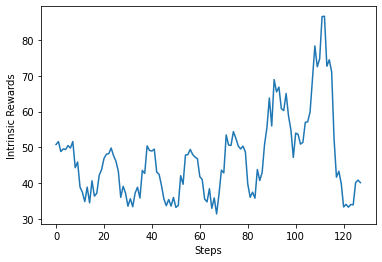

=== Rollout num. 1 ================================
[]


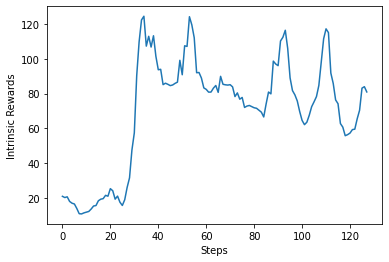

=== Rollout num. 2 ================================
[17]


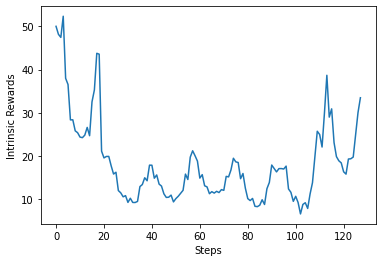

=== Rollout num. 3 ================================
[38, 60]


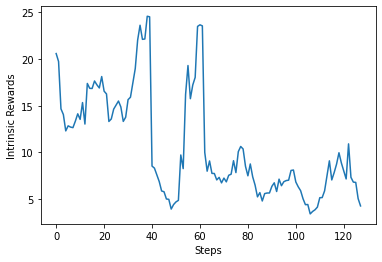

=== Rollout num. 4 ================================
[81]


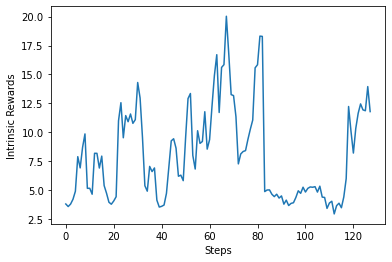

=== Rollout num. 5 ================================
[94]


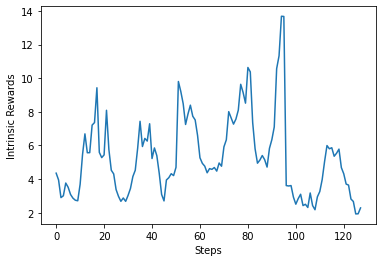

=== Rollout num. 6 ================================
[38]


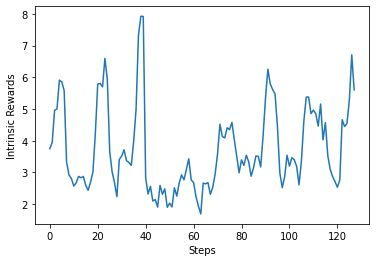

=== Rollout num. 7 ================================
[0, 55, 96]


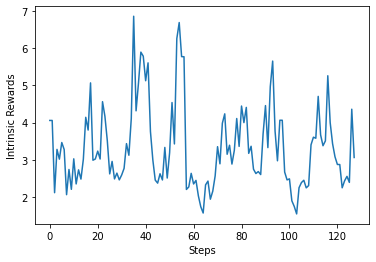

=== Rollout num. 8 ================================
[1]


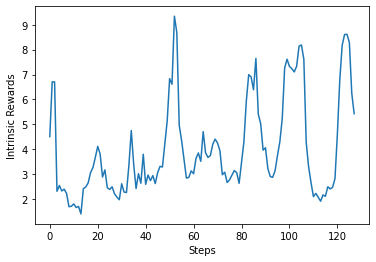

=== Rollout num. 9 ================================
[26]


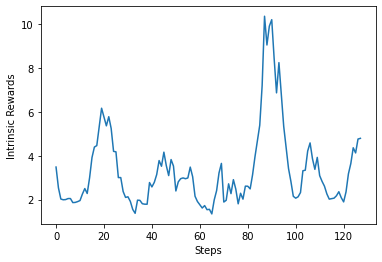

=== Rollout num. 10 ================================
[11, 42, 91]


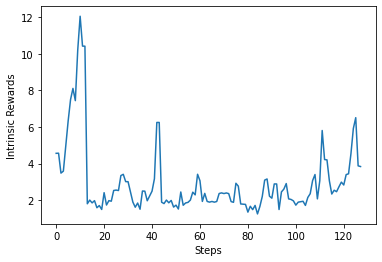

=== Rollout num. 11 ================================
[26, 59, 78, 97]


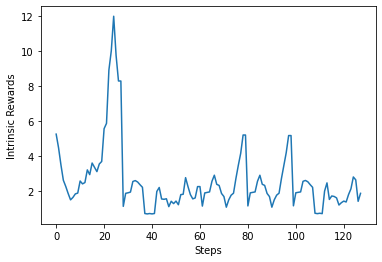

=== Rollout num. 12 ================================
[86]


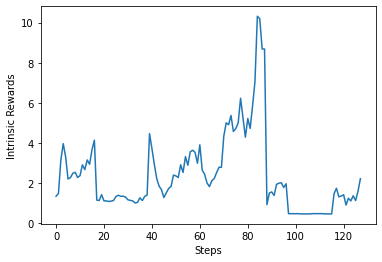

=== Rollout num. 13 ================================
[4]


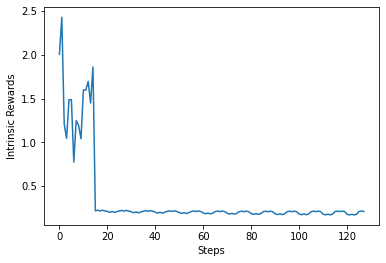

=== Rollout num. 14 ================================
[]


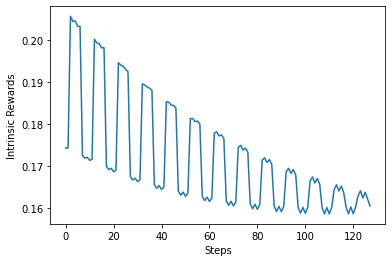

In [8]:
for i in range(len(intrinsic_rewards)):
    print("=== Rollout num. {} ================================".format(i))
    print(last_episode_step[i])

    steps = range(len(intrinsic_rewards[i])) #N_STEPS)#N_EPOCHS)

    plt.plot(steps, intrinsic_rewards[i])

    plt.xlabel("Steps")
    plt.ylabel("Intrinsic Rewards")

    plt.show()

=== Rollout num. 0 ================================
[]


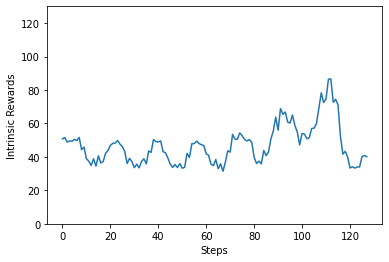

=== Rollout num. 1 ================================
[]


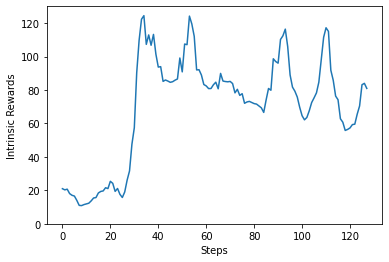

=== Rollout num. 2 ================================
[17]


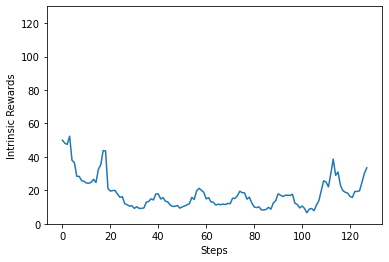

In [11]:
for i in range(3):
    print("=== Rollout num. {} ================================".format(i))
    print(last_episode_step[i])

    steps = range(len(intrinsic_rewards[i])) #N_STEPS)#N_EPOCHS)
    
    plt.plot(steps, intrinsic_rewards[i])

    plt.xlabel("Steps")
    plt.ylabel("Intrinsic Rewards")

    ax = plt.gca()
    ax.set_ylim([0, 130])
    
    plt.show()